In [3]:
import numpy as np
import tensorflow as tf
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras import models
from keras import layers
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from util.plots import plot_history
from nets.cnn_net.cnn_net import cnn_net
from glob import glob
import util.image_import as ii
from util.data_generator import make_data_generator 
import os
from keras.utils.np_utils import to_categorical

In [5]:
batch_size = 32
train_path = '../dataset2/res_still/train'
valid_path = '../dataset2/res_still/valid'
test_path = '../dataset2/res_still/test'
train_generator, validation_generator, test_generator = make_data_generator(train_path, test_path, val_path=valid_path, load_ram=True)

Found Training 573 images belonging to 3 classes
Found Validation 160 images belonging to 3 classes
Found Test 80 images belonging to 3 classes


In [6]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  #  3D activation map -> 1D vector
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.5)) 
model.add(Dense(3))                                 # Conv2D prøve (5,5) i stedet for (3,3)
model.add(Activation('softmax'))                    # MaxPooling2D prøv (4,4) i stedet for (2,2)
                                                    # lr = [1e-2, 1e-3, 1e-4]
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001, epsilon=10e-8),
              metrics=['accuracy'])

In [7]:
history = model.fit_generator(
            train_generator,
            steps_per_epoch=573 // batch_size,
            epochs=100,
            validation_data=validation_generator,
            validation_steps=160 // batch_size)

Epoch 1/100
17/17 [==============================] - 6s 351ms/step - loss: 1.2317 - acc: 0.3898 - val_loss: 0.9696 - val_acc: 0.3563
Epoch 2/100
17/17 [==============================] - 5s 272ms/step - loss: 0.8434 - acc: 0.6049 - val_loss: 0.7252 - val_acc: 0.7000
Epoch 3/100
17/17 [==============================] - 5s 284ms/step - loss: 0.6045 - acc: 0.7505 - val_loss: 0.4550 - val_acc: 0.9313
Epoch 4/100
17/17 [==============================] - 5s 269ms/step - loss: 0.4327 - acc: 0.8266 - val_loss: 0.2518 - val_acc: 0.9750
Epoch 5/100
17/17 [==============================] - 5s 278ms/step - loss: 0.3763 - acc: 0.8566 - val_loss: 0.1894 - val_acc: 0.9750
Epoch 6/100
17/17 [==============================] - 5s 280ms/step - loss: 0.3167 - acc: 0.8455 - val_loss: 0.1541 - val_acc: 0.9812
Epoch 7/100
17/17 [==============================] - 4s 263ms/step - loss: 0.2517 - acc: 0.9024 - val_loss: 0.1641 - val_acc: 0.9812
Epoch 8/100
17/17 [==============================] - 4s 260ms/step - 

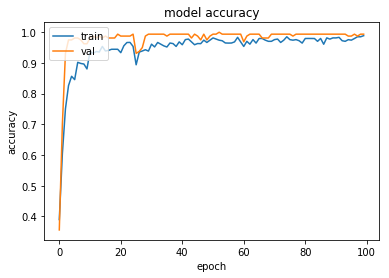

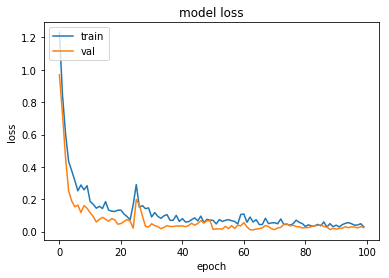

In [8]:
plot_history(history, save=True, path='nets/cnn_net/', name='cnn_full')

In [9]:
imgs, labels = next(test_generator)

model.evaluate(imgs,labels, batch_size=80)

32/32 [==============================] - 0s 949us/step


[0.408502995967865, 0.96875]

In [9]:
# serialize model to JSON
model_json = model.to_json()
with open("nets/cnn_net/model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("nets/cnn_net/model.h5")

In [9]:
# load json and create model
#json_file = open('model.json', 'r')
#loaded_model_json = json_file.read()
#json_file.close()
#loaded_model = model_from_json(loaded_model_json)
# load weights into new model
#loaded_model.load_weights("model.h5")
#print("Loaded model from disk")
 
# evaluate loaded model on test data
#loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
#score = loaded_model.evaluate(X, Y, verbose=0)

In [10]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 222, 222, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_2 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 186624)            0         
__________

## Hyperparameter optimization <span style="color:red"> DONE (Run again for better notebook order)!</span>

In [3]:
# Only work with tensorflow=1.8 and keras=2.1.6 because of the memory allocation

# Hyperparameters
learning_rates = [1e-2, 1e-3, 1e-4];
Conv2D_values = [3, 5]
MaxPooling2D_values = [2, 4]

history = []
result = None
results = []

for lr in learning_rates:
    for c in Conv2D_values:
        for p in MaxPooling2D_values:
            # GPU memory allocation
            cfg = K.tf.ConfigProto() # Create setup file for keras tensorflow
            cfg.gpu_options.allow_growth = True # Setting setup file with dynamically adding gpu memory
            K.set_session(K.tf.Session(config=cfg)) # Setting session to use setup file
            sess = tf.Session() 
            K.set_session(sess)# set this TensorFlow session as the default session for Keras.

            # Defining the model:
            model = Sequential()
            model.add(Conv2D(32, (c, c), input_shape=(224, 224, 3)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(p, p)))

            model.add(Conv2D(64, (c, c)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(p, p)))

            model.add(Flatten())  #  3D activation map -> 1D vector
            model.add(Dense(32))
            model.add(Activation('relu'))
            model.add(Dropout(0.5)) 
            model.add(Dense(3))                                
            model.add(Activation('softmax'))                    
                                                            
            model.compile(loss='categorical_crossentropy',
                          optimizer=Adam(lr=lr, epsilon=10e-8),
                          metrics=['accuracy'])

            # Running the model:
            temp = (model.fit_generator(
                train_generator,
                steps_per_epoch=573 // batch_size,
                epochs=100,
                validation_data=validation_generator,
                validation_steps=160 // batch_size))

            # Saving the results
            history.append(temp)
            train_acc = temp.history['acc'].pop()
            val_acc = temp.history['val_acc'].pop()
            result = (lr, c, p, train_acc, val_acc)
            results.append(result)
            del model
            K.clear_session() # Clearing the session to clear out gpu memory


Epoch 1/100
17/17 [==============================] - 5s 300ms/step - loss: 6.7658 - acc: 0.3992 - val_loss: 0.7441 - val_acc: 0.6375
Epoch 2/100
17/17 [==============================] - 5s 282ms/step - loss: 0.9736 - acc: 0.6453 - val_loss: 0.6617 - val_acc: 0.6813
Epoch 3/100
17/17 [==============================] - 6s 324ms/step - loss: 0.6185 - acc: 0.7132 - val_loss: 0.6120 - val_acc: 0.7125
Epoch 4/100
17/17 [==============================] - 5s 307ms/step - loss: 0.5041 - acc: 0.7428 - val_loss: 0.4912 - val_acc: 0.7312
Epoch 5/100
17/17 [==============================] - 5s 320ms/step - loss: 0.5273 - acc: 0.7482 - val_loss: 0.5625 - val_acc: 0.9000
Epoch 6/100
17/17 [==============================] - 6s 365ms/step - loss: 0.5529 - acc: 0.7540 - val_loss: 0.5618 - val_acc: 0.6875
Epoch 7/100
17/17 [==============================] - 6s 356ms/step - loss: 0.5688 - acc: 0.7538 - val_loss: 0.5524 - val_acc: 0.6375
Epoch 8/100
17/17 [==============================] - 6s 346ms/step - 

Epoch 23/100
17/17 [==============================] - 5s 288ms/step - loss: 0.3118 - acc: 0.8525 - val_loss: 0.2366 - val_acc: 0.9812
Epoch 24/100
17/17 [==============================] - 5s 285ms/step - loss: 0.3320 - acc: 0.8474 - val_loss: 0.2815 - val_acc: 0.9500
Epoch 25/100
17/17 [==============================] - 5s 290ms/step - loss: 0.3672 - acc: 0.8178 - val_loss: 0.3570 - val_acc: 0.9688
Epoch 26/100
17/17 [==============================] - 5s 280ms/step - loss: 0.3284 - acc: 0.8728 - val_loss: 0.2397 - val_acc: 0.9812
Epoch 27/100
17/17 [==============================] - 5s 286ms/step - loss: 0.3354 - acc: 0.8654 - val_loss: 0.2608 - val_acc: 0.9688
Epoch 28/100
17/17 [==============================] - 5s 294ms/step - loss: 0.2280 - acc: 0.9007 - val_loss: 0.2395 - val_acc: 0.9688
Epoch 29/100
17/17 [==============================] - 5s 284ms/step - loss: 0.2236 - acc: 0.9095 - val_loss: 0.1878 - val_acc: 0.9875
Epoch 30/100
17/17 [==============================] - 5s 283ms

17/17 [==============================] - 5s 292ms/step - loss: 1.0844 - acc: 0.3908 - val_loss: 1.0822 - val_acc: 0.3750
Epoch 46/100
17/17 [==============================] - 5s 292ms/step - loss: 1.0750 - acc: 0.3750 - val_loss: 1.0823 - val_acc: 0.3750
Epoch 47/100
17/17 [==============================] - 5s 288ms/step - loss: 1.0826 - acc: 0.3505 - val_loss: 1.0823 - val_acc: 0.3750
Epoch 48/100
17/17 [==============================] - 5s 297ms/step - loss: 1.0803 - acc: 0.3787 - val_loss: 1.0823 - val_acc: 0.3750
Epoch 49/100
17/17 [==============================] - 5s 283ms/step - loss: 1.0865 - acc: 0.3534 - val_loss: 1.0822 - val_acc: 0.3750
Epoch 50/100
17/17 [==============================] - 5s 289ms/step - loss: 1.0709 - acc: 0.3603 - val_loss: 1.0823 - val_acc: 0.3750
Epoch 51/100
17/17 [==============================] - 5s 290ms/step - loss: 1.0788 - acc: 0.3693 - val_loss: 1.0824 - val_acc: 0.3750
Epoch 52/100
17/17 [==============================] - 5s 294ms/step - loss:

17/17 [==============================] - 5s 285ms/step - loss: 0.4333 - acc: 0.8036 - val_loss: 0.4735 - val_acc: 0.7375
Epoch 68/100
17/17 [==============================] - 5s 285ms/step - loss: 0.3960 - acc: 0.8199 - val_loss: 0.4768 - val_acc: 0.7375
Epoch 69/100
17/17 [==============================] - 5s 286ms/step - loss: 0.3866 - acc: 0.8016 - val_loss: 0.4667 - val_acc: 0.7312
Epoch 70/100
17/17 [==============================] - 5s 281ms/step - loss: 0.3999 - acc: 0.8309 - val_loss: 0.4725 - val_acc: 0.7250
Epoch 71/100
17/17 [==============================] - 5s 308ms/step - loss: 0.3764 - acc: 0.8321 - val_loss: 0.4687 - val_acc: 0.7375
Epoch 72/100
17/17 [==============================] - 5s 303ms/step - loss: 0.3772 - acc: 0.8318 - val_loss: 0.4602 - val_acc: 0.7312
Epoch 73/100
17/17 [==============================] - 5s 294ms/step - loss: 0.3485 - acc: 0.8474 - val_loss: 0.4684 - val_acc: 0.7312
Epoch 74/100
17/17 [==============================] - 5s 287ms/step - loss:

17/17 [==============================] - 5s 295ms/step - loss: 0.0486 - acc: 0.9739 - val_loss: 0.0106 - val_acc: 0.9938
Epoch 90/100
17/17 [==============================] - 5s 297ms/step - loss: 0.0316 - acc: 0.9926 - val_loss: 0.0184 - val_acc: 0.9938
Epoch 91/100
17/17 [==============================] - 5s 298ms/step - loss: 0.0338 - acc: 0.9853 - val_loss: 0.0145 - val_acc: 0.9938
Epoch 92/100
17/17 [==============================] - 5s 286ms/step - loss: 0.0400 - acc: 0.9925 - val_loss: 0.0103 - val_acc: 0.9938
Epoch 93/100
17/17 [==============================] - 5s 286ms/step - loss: 0.0348 - acc: 0.9890 - val_loss: 0.0217 - val_acc: 0.9938
Epoch 94/100
17/17 [==============================] - 5s 286ms/step - loss: 0.0414 - acc: 0.9816 - val_loss: 0.0145 - val_acc: 0.9938
Epoch 95/100
17/17 [==============================] - 5s 292ms/step - loss: 0.0220 - acc: 0.9926 - val_loss: 0.0185 - val_acc: 0.9938
Epoch 96/100
17/17 [==============================] - 5s 285ms/step - loss:

17/17 [==============================] - 6s 337ms/step - loss: 0.2463 - acc: 0.9244 - val_loss: 0.1427 - val_acc: 0.9875
Epoch 12/100
17/17 [==============================] - 6s 341ms/step - loss: 0.2923 - acc: 0.8890 - val_loss: 0.2339 - val_acc: 0.9125
Epoch 13/100
17/17 [==============================] - 6s 342ms/step - loss: 0.2874 - acc: 0.9077 - val_loss: 0.1516 - val_acc: 0.9812
Epoch 14/100
17/17 [==============================] - 6s 342ms/step - loss: 0.2669 - acc: 0.9070 - val_loss: 0.0703 - val_acc: 0.9812
Epoch 15/100
17/17 [==============================] - 6s 332ms/step - loss: 0.2341 - acc: 0.9373 - val_loss: 0.0783 - val_acc: 0.9812
Epoch 16/100
17/17 [==============================] - 6s 336ms/step - loss: 0.2124 - acc: 0.9189 - val_loss: 0.0827 - val_acc: 0.9750
Epoch 17/100
17/17 [==============================] - 6s 345ms/step - loss: 0.2248 - acc: 0.9239 - val_loss: 0.0806 - val_acc: 0.9812
Epoch 18/100
17/17 [==============================] - 6s 344ms/step - loss:

17/17 [==============================] - 6s 331ms/step - loss: 0.1305 - acc: 0.9428 - val_loss: 0.0898 - val_acc: 0.9812
Epoch 34/100
17/17 [==============================] - 6s 330ms/step - loss: 0.1301 - acc: 0.9518 - val_loss: 0.0860 - val_acc: 0.9812
Epoch 35/100
17/17 [==============================] - 6s 335ms/step - loss: 0.1547 - acc: 0.9522 - val_loss: 0.0775 - val_acc: 0.9812
Epoch 36/100
17/17 [==============================] - 6s 325ms/step - loss: 0.1374 - acc: 0.9467 - val_loss: 0.0724 - val_acc: 0.9812
Epoch 37/100
17/17 [==============================] - 6s 340ms/step - loss: 0.1401 - acc: 0.9320 - val_loss: 0.0699 - val_acc: 0.9812
Epoch 38/100
17/17 [==============================] - 6s 339ms/step - loss: 0.1306 - acc: 0.9430 - val_loss: 0.0680 - val_acc: 0.9875
Epoch 39/100
17/17 [==============================] - 6s 338ms/step - loss: 0.1413 - acc: 0.9426 - val_loss: 0.0737 - val_acc: 0.9812
Epoch 40/100
17/17 [==============================] - 5s 321ms/step - loss:

17/17 [==============================] - 6s 332ms/step - loss: 0.2766 - acc: 0.8562 - val_loss: 0.1225 - val_acc: 0.9812
Epoch 56/100
17/17 [==============================] - 6s 335ms/step - loss: 0.2236 - acc: 0.8853 - val_loss: 0.1148 - val_acc: 0.9875
Epoch 57/100
17/17 [==============================] - 6s 333ms/step - loss: 0.2311 - acc: 0.8901 - val_loss: 0.0942 - val_acc: 0.9812
Epoch 58/100
17/17 [==============================] - 6s 343ms/step - loss: 0.2107 - acc: 0.9265 - val_loss: 0.1072 - val_acc: 0.9812
Epoch 59/100
17/17 [==============================] - 6s 332ms/step - loss: 0.2578 - acc: 0.8755 - val_loss: 0.1134 - val_acc: 0.9812
Epoch 60/100
17/17 [==============================] - 6s 334ms/step - loss: 0.2176 - acc: 0.9081 - val_loss: 0.1056 - val_acc: 0.9750
Epoch 61/100
17/17 [==============================] - 6s 335ms/step - loss: 0.2374 - acc: 0.8801 - val_loss: 0.0915 - val_acc: 0.9812
Epoch 62/100
17/17 [==============================] - 6s 337ms/step - loss:

17/17 [==============================] - 5s 280ms/step - loss: 0.1759 - acc: 0.9355 - val_loss: 0.1303 - val_acc: 0.9688
Epoch 78/100
17/17 [==============================] - 5s 281ms/step - loss: 0.1598 - acc: 0.9428 - val_loss: 0.1559 - val_acc: 0.9563
Epoch 79/100
17/17 [==============================] - 5s 285ms/step - loss: 0.1647 - acc: 0.9539 - val_loss: 0.1316 - val_acc: 0.9625
Epoch 80/100
17/17 [==============================] - 5s 284ms/step - loss: 0.1766 - acc: 0.9577 - val_loss: 0.1634 - val_acc: 0.9500
Epoch 81/100
17/17 [==============================] - 5s 283ms/step - loss: 0.1794 - acc: 0.9537 - val_loss: 0.1608 - val_acc: 0.9500
Epoch 82/100
17/17 [==============================] - 5s 282ms/step - loss: 0.1678 - acc: 0.9476 - val_loss: 0.1543 - val_acc: 0.9500
Epoch 83/100
17/17 [==============================] - 5s 282ms/step - loss: 0.1654 - acc: 0.9406 - val_loss: 0.1744 - val_acc: 0.9500
Epoch 84/100
17/17 [==============================] - 5s 281ms/step - loss:

17/17 [==============================] - 5s 283ms/step - loss: 0.1100 - acc: 0.9320 - val_loss: 0.0268 - val_acc: 0.9875
Epoch 100/100
17/17 [==============================] - 5s 284ms/step - loss: 0.1098 - acc: 0.9520 - val_loss: 0.0218 - val_acc: 0.9875
Epoch 1/100
17/17 [==============================] - 5s 289ms/step - loss: 1.0797 - acc: 0.3900 - val_loss: 1.0486 - val_acc: 0.4688
Epoch 2/100
17/17 [==============================] - 5s 282ms/step - loss: 1.0308 - acc: 0.4197 - val_loss: 1.0011 - val_acc: 0.3937
Epoch 3/100
17/17 [==============================] - 5s 288ms/step - loss: 0.9695 - acc: 0.5304 - val_loss: 0.9503 - val_acc: 0.5437
Epoch 4/100
17/17 [==============================] - 5s 289ms/step - loss: 0.9308 - acc: 0.5396 - val_loss: 0.9131 - val_acc: 0.5125
Epoch 5/100
17/17 [==============================] - 5s 285ms/step - loss: 0.8933 - acc: 0.5423 - val_loss: 0.8573 - val_acc: 0.5750
Epoch 6/100
17/17 [==============================] - 5s 279ms/step - loss: 0.83

#### Printing all results and plotting only the best validation accuracy

In [4]:
best_valacc_indices = []
highest_valacc = 0
for index, r in enumerate(results):
    print('learning rate %e conv size %i pool size %i train accuracy: %f val accuracy: %f' % r) 
    if highest_valacc < r[4]:
        best_valacc_indices = [] # Empty the list because of better value
        best_valacc_indices.append(index)
        highest_valacc = r[4]
    elif highest_valacc == r[4]:
        best_valacc_indices.append(index)

learning rate 1.000000e-02 conv size 3 pool size 2 train accuracy: 0.964880 val accuracy: 1.000000
learning rate 1.000000e-02 conv size 3 pool size 4 train accuracy: 0.972274 val accuracy: 0.981250
learning rate 1.000000e-02 conv size 5 pool size 2 train accuracy: 0.378928 val accuracy: 0.375000
learning rate 1.000000e-02 conv size 5 pool size 4 train accuracy: 0.788104 val accuracy: 0.737500
learning rate 1.000000e-03 conv size 3 pool size 2 train accuracy: 0.979779 val accuracy: 0.993750
learning rate 1.000000e-03 conv size 3 pool size 4 train accuracy: 0.987132 val accuracy: 0.987500
learning rate 1.000000e-03 conv size 5 pool size 2 train accuracy: 0.975836 val accuracy: 0.993750
learning rate 1.000000e-03 conv size 5 pool size 4 train accuracy: 0.975970 val accuracy: 0.987500
learning rate 1.000000e-04 conv size 3 pool size 2 train accuracy: 0.918669 val accuracy: 0.987500
learning rate 1.000000e-04 conv size 3 pool size 4 train accuracy: 0.972274 val accuracy: 0.950000
learning r

______________________________________________________________________
learning rate 1.000000e-02 conv size 3 pool size 2 train accuracy: 0.964880 val accuracy: 1.000000


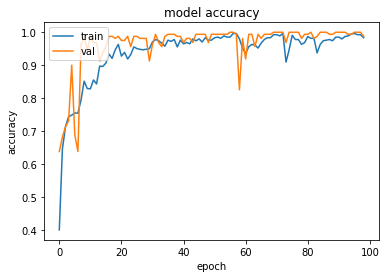

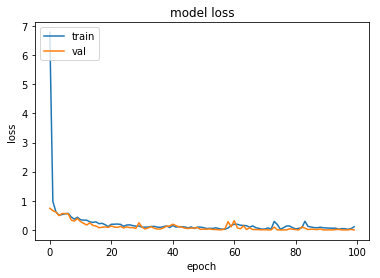

In [5]:
for indices in best_valacc_indices:
    print("______________________________________________________________________")
    print('learning rate %e conv size %i pool size %i train accuracy: %f val accuracy: %f' % results[indices])         
    plot_history(history[indices], mean_N=1)

**Based on results above of the training and validation accuracy and the plot above the traning is done again for the following hyperparameters to check which are best:** 
1. ```
Learning rate       = 1e-2
Convolutional size  = (3,3)
Pooling size        = (2,2)
```
2. ```
Learning rate       = 1e-3
Convolutional size  = (3,3)
Pooling size        = (2,2)
```

In [9]:
# Only work with tensorflow=1.8 and keras=2.1.6 because of the memory allocation

# Hyperparameters
learning_rates = [1e-2, 1e-3];
Conv2D_values = [3]
MaxPooling2D_values = [2]

history = []
result = None
results = []

for lr in learning_rates:
    for c in Conv2D_values
        for p in MaxPooling2D_values:
            # GPU memory allocation
            cfg = K.tf.ConfigProto() # Create setup file for keras tensorflow
            cfg.gpu_options.allow_growth = True # Setting setup file with dynamically adding gpu memory
            K.set_session(K.tf.Session(config=cfg)) # Setting session to use setup file
            sess = tf.Session() 
            K.set_session(sess)# set this TensorFlow session as the default session for Keras.

            # Defining the model:
            model = Sequential()
            model.add(Conv2D(32, (c, c), input_shape=(224, 224, 3)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(p, p)))

            model.add(Conv2D(64, (c, c)))
            model.add(Activation('relu'))
            model.add(MaxPooling2D(pool_size=(p, p)))

            model.add(Flatten())  #  3D activation map -> 1D vector
            model.add(Dense(32))
            model.add(Activation('relu'))
            model.add(Dropout(0.5)) 
            model.add(Dense(3))                                
            model.add(Activation('softmax'))                    
                                                            
            model.compile(loss='categorical_crossentropy',
                          optimizer=Adam(lr=lr, epsilon=10e-8),
                          metrics=['accuracy'])

            # Running the model:
            temp = (model.fit_generator(
                train_generator,
                steps_per_epoch=573 // batch_size,
                epochs=100,
                validation_data=validation_generator,
                validation_steps=160 // batch_size))

            # Saving the results
            history.append(temp)
            train_acc = temp.history['acc'].pop()
            val_acc = temp.history['val_acc'].pop()
            result = (lr, c, p, train_acc, val_acc)
            results.append(result)
            del model
            K.clear_session() # Clearing the session to clear out gpu memory


Epoch 1/100
17/17 [==============================] - 5s 278ms/step - loss: 3.7854 - acc: 0.3254 - val_loss: 1.0725 - val_acc: 0.5125
Epoch 2/100
17/17 [==============================] - 5s 267ms/step - loss: 0.9715 - acc: 0.4786 - val_loss: 0.8926 - val_acc: 0.6375
Epoch 3/100
17/17 [==============================] - 5s 267ms/step - loss: 0.8143 - acc: 0.6597 - val_loss: 0.6702 - val_acc: 0.7188
Epoch 4/100
17/17 [==============================] - 5s 275ms/step - loss: 0.6681 - acc: 0.7224 - val_loss: 0.5728 - val_acc: 0.7188
Epoch 5/100
17/17 [==============================] - 5s 279ms/step - loss: 0.5999 - acc: 0.7141 - val_loss: 0.4951 - val_acc: 0.7375
Epoch 6/100
17/17 [==============================] - 5s 278ms/step - loss: 0.5821 - acc: 0.7270 - val_loss: 0.5405 - val_acc: 0.7375
Epoch 7/100
17/17 [==============================] - 5s 278ms/step - loss: 0.5414 - acc: 0.7298 - val_loss: 0.4801 - val_acc: 0.7375
Epoch 8/100
17/17 [==============================] - 5s 268ms/step - 

17/17 [==============================] - 5s 317ms/step - loss: 0.2027 - acc: 0.9357 - val_loss: 0.0511 - val_acc: 0.9875
Epoch 24/100
17/17 [==============================] - 5s 283ms/step - loss: 0.1434 - acc: 0.9573 - val_loss: 0.0476 - val_acc: 0.9812
Epoch 25/100
17/17 [==============================] - 5s 308ms/step - loss: 0.1195 - acc: 0.9706 - val_loss: 0.0363 - val_acc: 0.9875
Epoch 26/100
17/17 [==============================] - 5s 290ms/step - loss: 0.1545 - acc: 0.9572 - val_loss: 0.0327 - val_acc: 0.9875
Epoch 27/100
17/17 [==============================] - 5s 277ms/step - loss: 0.1640 - acc: 0.9485 - val_loss: 0.0318 - val_acc: 0.9875
Epoch 28/100
17/17 [==============================] - 5s 287ms/step - loss: 0.1461 - acc: 0.9539 - val_loss: 0.0275 - val_acc: 0.9875
Epoch 29/100
17/17 [==============================] - 5s 294ms/step - loss: 0.1741 - acc: 0.9577 - val_loss: 0.0229 - val_acc: 0.9875
Epoch 30/100
17/17 [==============================] - 5s 311ms/step - loss:

______________________________________________________________________
learning rate 1.000000e-02 conv size 3 pool size 2 train accuracy: 0.966912 val accuracy: 0.981250


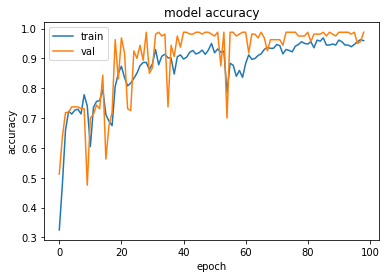

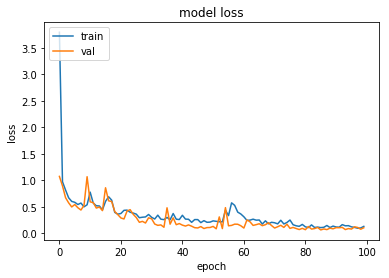

______________________________________________________________________
learning rate 1.000000e-03 conv size 3 pool size 2 train accuracy: 0.975836 val accuracy: 0.987500


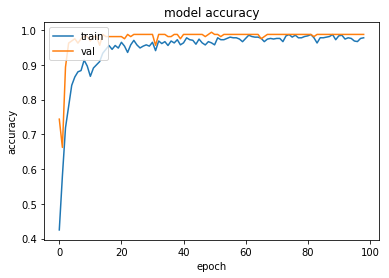

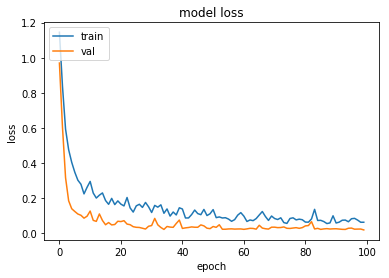

In [10]:
for indices, h in enumerate(history):
    print("______________________________________________________________________")
    print('learning rate %e conv size %i pool size %i train accuracy: %f val accuracy: %f' % results[indices])         
    plot_history(h, mean_N=1)

**Based on graph and results above of the training and validation accuracy the following hyperparameters is found to be the optimal:** 
```
Learning rate       = 1e-3
Convolutional size  = (3,3)
Pooling size        = (2,2)
```
**Which gives the following results for 100 epoch for 1 training run:**
```
Train accuracy      = 0.975836
Validation accuracy = 0.987500
```